# Olympic games medals analysis


In this notebook we will analyze `olimpic_medals.csv` dataset for pandas skill training.



<sub><sup>Homework for EPAM Training Center, Nizhny Novgorod, Russia, 2020</sup></sub>

### First install useful libs and make imports

In [1]:
%pip install -r requirements.txt

In [2]:
import pandas as pd
from iso3166 import countries

from codes_mapping import ioc2iso

### Then load dataset and take quick look at data

In [3]:
dset = pd.read_csv('olimpic_medals.csv')
dset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29216 entries, 0 to 29215
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   City          29216 non-null  object
 1   Edition       29216 non-null  int64 
 2   Sport         29216 non-null  object
 3   Discipline    29216 non-null  object
 4   Athlete       29216 non-null  object
 5   NOC           29216 non-null  object
 6   Gender        29216 non-null  object
 7   Event         29216 non-null  object
 8   Event_gender  29216 non-null  object
 9   Medal         29216 non-null  object
dtypes: int64(1), object(9)
memory usage: 2.2+ MB


In [4]:
dset.head(3)

,City,Edition,Sport,Discipline,Athlete,NOC,Gender,Event,Event_gender,Medal
0,Athens,1896,Aquatics,Swimming,"HAJOS, Alfred",HUN,Men,100m freestyle,M,Gold
1,Athens,1896,Aquatics,Swimming,"HERSCHMANN, Otto",AUT,Men,100m freestyle,M,Silver
2,Athens,1896,Aquatics,Swimming,"DRIVAS, Dimitrios",GRE,Men,100m freestyle for sailors,M,Bronze


### Define some useful functions

In [5]:
def get_country_name(alpha3code: str) -> str:
    """Map codes between IOC and ISO formats according to Wikipedia article
    (https://en.wikipedia.org/wiki/Comparison_of_alphabetic_country_codes), exclude 
    former countries and former country names. Return regular country name (from ISO-3166).   
    
    Args:
      alpha3code: three-letter country code
      
    Returns:
      regular country name"""
    
    try:
        return countries.get(ioc2iso.get(alpha3code, alpha3code)).name
    
    except KeyError:
        return alpha3code

### Analysis

#### 1. How many medals did Jesse Owens get in 1936 year?

Since athlete names are stored as pair of "family name / first name", let's switch name and family name in condition. Thus we are searching 'OWENS, Jesse' now. 
However usually is better to normalize strings to lowercase when searching, that's what we do.

In [6]:
mask_year1936 = dset.Edition == 1936
mask_jesse = dset.Athlete.str.lower() == 'Owens, Jesse'.lower()

cnt = len(dset[(mask_year1936 & mask_jesse)])

f'Jesse Owens got {cnt} medal(s) in 1936' 

'Jesse Owens got 4 medal(s) in 1936'

#### 2. Which country has won more gold medals in Badminton (men) than others?

In [7]:
mask_medal = dset.Medal == 'Gold'
mask_gender = dset.Event_gender == 'M'
mask_badminton = dset.Discipline == 'Badminton'
 
alpha3code = dset[(mask_medal & mask_gender & mask_badminton)].NOC.value_counts().idxmax()  # country code
country_name = get_country_name(alpha3code)

f'Men of {country_name} ({alpha3code}) have won more gold medals in Badminton than others.'

'Men of Indonesia (INA) have won more gold medals in Badminton than others.'

#### 3. Which three countries have won more medals  than others from 1984 to 2008?

In [8]:
mask_years = dset.Edition >= 1984
top3 = dset[mask_years].groupby('NOC').count().sort_values(by='Medal', ascending=False)['Medal'][:3]
top3.index = top3.index.map(lambda x: f'{get_country_name(x)} ({x})')

top3

NOC
United States of America (USA)    1837
Australia (AUS)                    762
Germany (GER)                      691
Name: Medal, dtype: int64

#### 4. Men who won gold medals in 100m sprint

In [9]:
mask_medal = dset.Medal == 'Gold'
mask_gender = dset.Event_gender == 'M'
mask_100m = dset.Event == '100m'

show_cols =['City', 'Edition', 'Athlete', 'NOC']
sprint_winners = dset[(mask_medal & mask_gender & mask_100m)][show_cols].sort_values(by='Edition',
                                                                                     ascending=False)

sprint_winners.NOC = sprint_winners.NOC.map(lambda x: f'{get_country_name(x)} ({x})')

sprint_winners

,City,Edition,Athlete,NOC
27552,Beijing,2008,"BOLT, Usain",Jamaica (JAM)
25539,Athens,2004,"GATLIN, Justin",United States of America (USA)
23521,Sydney,2000,"GREENE, Maurice",United States of America (USA)
21598,Atlanta,1996,"BAILEY, Donovan",Canada (CAN)
19859,Barcelona,1992,"CHRISTIE, Linford",United Kingdom of Great Britain and Northern I...
18284,Seoul,1988,"LEWIS, Carl",United States of America (USA)
16794,Los Angeles,1984,"LEWIS, Carl",United States of America (USA)
15374,Moscow,1980,"WELLS, Allan",United Kingdom of Great Britain and Northern I...
14069,Montreal,1976,"CRAWFORD, Hasely",Trinidad and Tobago (TRI)
12902,Munich,1972,"BORZOV, Valery",URS (URS)


#### 5.1 How many medals did men and women win? 

In [10]:
mask_gender_m = dset.Gender == 'Men'
mask_gender_w = dset.Gender == 'Women'

print(f'Men won {len(dset[mask_gender_m])} medals\nWomen won {len(dset[mask_gender_w])} medals')

Men won 21721 medals
Women won 7495 medals


#### 5.2 How many gold, silver and bronze medals have won each gender?

In [11]:
medal_distribution = dset.groupby(['Gender', 'Medal'])['Medal'].agg('count')
medal_distribution

Gender  Medal 
Men     Bronze    7175
        Gold      7365
        Silver    7181
Women   Bronze    2514
        Gold      2485
        Silver    2496
Name: Medal, dtype: int64

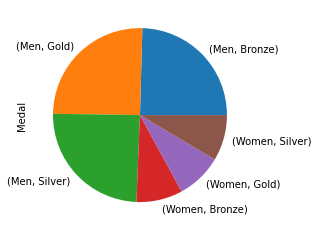

In [12]:
medal_distribution.plot.pie()

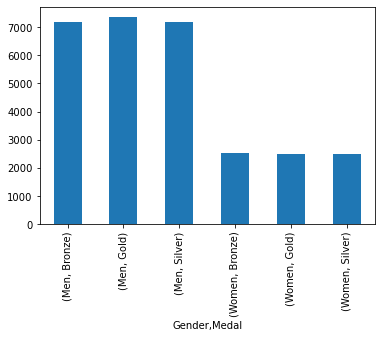

In [13]:
medal_distribution.plot.bar()

#### 6. Count of medals on each Olympics

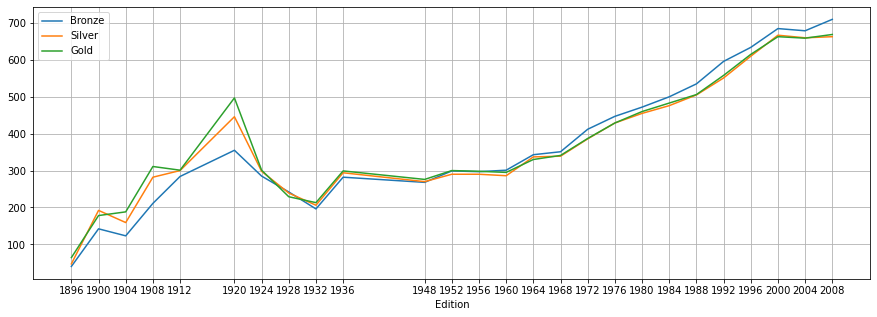

In [14]:
cols = { 
    'Bronze': dset[dset.loc[:, 'Medal'] == 'Bronze'].groupby('Edition').agg('count')['Medal'],
    'Silver': dset[dset.loc[:, 'Medal'] == 'Silver'].groupby('Edition').agg('count')['Medal'],
    'Gold': dset[dset.loc[:, 'Medal'] == 'Gold'].groupby('Edition').agg('count')['Medal'],
}

xticks = sorted(list(set(dset.Edition)))

pd.DataFrame(cols).plot(figsize=(15,5), xticks=xticks, grid=True)

#### 7. Count of medals by countries

In [15]:
medal_count = dset.groupby('NOC')['Medal'].agg('count')
medal_first = dset.groupby('NOC')['Edition'].agg('min')
medal_last = dset.groupby('NOC')['Edition'].agg('max')

result = pd.DataFrame([medal_count, medal_first, medal_last]).T
result.columns = ['Count', 'First', 'Last']
result.index = result.index.map(lambda x: f'{get_country_name(x)} ({x})')

pd.set_option('display.max_rows', len(result))
result

,Count,First,Last
NOC,,,
Afghanistan (AFG),1,2008,2008
AHO (AHO),1,1988,1988
Algeria (ALG),14,1984,2008
ANZ (ANZ),29,1908,1912
Argentina (ARG),239,1924,2008
Armenia (ARM),9,1996,2008
Australia (AUS),1075,1896,2008
Austria (AUT),146,1896,2008
Azerbaijan (AZE),16,1996,2008


#### 8. Athletes on 200m or 100m distances with medals in Beijing

In [16]:
mask_beijing = dset.City == 'Beijing'
mask_discipline = (dset.Event == '100m') | (dset.Event == '200m')
dset[mask_beijing & mask_discipline]

,City,Edition,Sport,Discipline,Athlete,NOC,Gender,Event,Event_gender,Medal
27551,Beijing,2008,Athletics,Athletics,"DIX, Walter",USA,Men,100m,M,Bronze
27552,Beijing,2008,Athletics,Athletics,"BOLT, Usain",JAM,Men,100m,M,Gold
27553,Beijing,2008,Athletics,Athletics,"THOMPSON, Richard",TRI,Men,100m,M,Silver
27554,Beijing,2008,Athletics,Athletics,"FRASER, Shelly-ann",JAM,Women,100m,W,Gold
27555,Beijing,2008,Athletics,Athletics,"SIMPSON, Sherone",JAM,Women,100m,W,Silver
27556,Beijing,2008,Athletics,Athletics,"STEWART, Kerron",JAM,Women,100m,W,Silver
27569,Beijing,2008,Athletics,Athletics,"DIX, Walter",USA,Men,200m,M,Bronze
27570,Beijing,2008,Athletics,Athletics,"BOLT, Usain",JAM,Men,200m,M,Gold
27571,Beijing,2008,Athletics,Athletics,"CRAWFORD, Shawn",USA,Men,200m,M,Silver
27572,Beijing,2008,Athletics,Athletics,"STEWART, Kerron",JAM,Women,200m,W,Bronze


#### 9. USA gold medals for men and women in Athletics

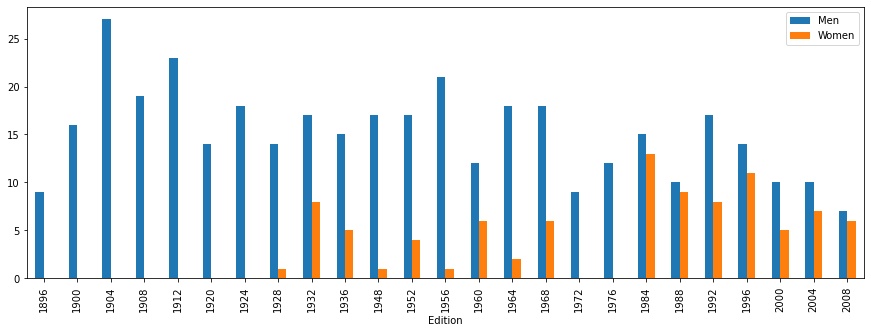

In [17]:
mask_athletics = dset.Discipline == 'Athletics'
mask_medal = dset.Medal == 'Gold'
mask_usa = dset.NOC == 'USA'
mask_m = dset.Gender == 'Men'
mask_w = dset.Gender == 'Women'

cols = {
    'Men': dset[mask_athletics & mask_medal & mask_usa & mask_m].groupby('Edition').agg('count')['Medal'],
    'Women': dset[mask_athletics & mask_medal & mask_usa & mask_w].groupby('Edition').agg('count')['Medal']
}

pd.DataFrame(cols).plot(kind='bar', figsize=(15,5))

#### 10. Top 5 athletes by gold medal count

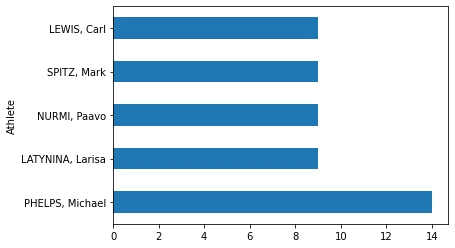

In [18]:
dset[dset.Medal == 'Gold'].groupby('Athlete').agg('count')['Medal'].sort_values(ascending=False)[:5].plot(kind='barh')

#### 11. Count medals on last Olympics

In [19]:
last_year = dset.Edition.max()
medal_count = dset[dset.Edition == last_year].agg('count')['Medal']

f'Total medals got in {last_year} year is {medal_count}.'

'Total medals got in 2008 year is 2042.'

#### 12. Top US athletes by years

In [20]:
us_only = dset[dset.loc[:, 'NOC'] == 'USA']

year_groups = us_only.groupby(['Edition', 'Athlete', 'Discipline']).agg('count').reset_index()

result = year_groups.loc[year_groups.groupby('Edition')['Medal'].idxmax()]
result = result.loc[:, ['Edition', 'Athlete', 'Discipline', 'Medal']]
result.columns = ['Year', 'Athlete', 'Discipline', 'Medal_count']

result

,Year,Athlete,Discipline,Medal_count
5,1896,"GARRETT, Robert",Athletics,4
14,1900,"BAXTER, Irving",Athletics,5
101,1904,"DOWNING, Burton",Cycling Track,6
369,1908,"SHEPPARD, Melvin",Athletics,3
428,1912,"OSBURN, Carl Townsend",Shooting,4
514,1920,"LEE, Willis",Shooting,7
617,1924,"EDERLE, Gertrude",Swimming,3
759,1928,"BARBUTI, Raymond James",Athletics,2
871,1932,"DIDRIKSON, Mildred",Athletics,3
1040,1936,"OWENS, Jesse",Athletics,4
